<a href="https://colab.research.google.com/github/ndrep/bioinformatics/blob/main/Bioinformatic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive

In [1]:
from google.colab import drive

drive.mount("/drive/")

Mounted at /drive/


#Installing requirements

In [2]:
!pip install -q "cache_decorator[all]"==2.0.8 humanize scikit-learn
!pip install -q barplots plot_keras_history epigenomic_dataset>=1.1.7
!pip install -q ucsc_genomes_downloader>=1.1.22 keras_bed_sequence>=1.1.5
!pip install -q keras_mixed_sequence ray seaborn minepy boruta prince cmake
!pip install -q multicoretsne silence_tensorflow>=1.1.1
!pip install tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies
!pip install -q faiss tbb
!pip install extra_keras_metrics
!pip install -U keras-tuner

     |████████████████████████████████| 98 kB 1.9 MB/s 
     |████████████████████████████████| 57.6 MB 1.2 MB/s 
     |████████████████████████████████| 495 kB 49.7 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 119 kB 51.8 MB/s 
Looking in links: https://tsnecuda.isx.ai/tsnecuda_stable.html
     |████████████████████████████████| 55.4 MB 1.3 MB/s 
     |████████████████████████████████| 4.7 MB 2.0 MB/s 
     |████████████████████████████████| 4.0 MB 37.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsnecuda 3.0.0+cu110 requires faiss==1.6.5, but you have faiss 1.5.3 which is incompatible.
  Created wheel for extra-keras-metrics: filename=extra_keras_metrics-2.0.5-py3-none-any.whl size=14204 sha256=3ed2fbc4ddef4bec5d20517b1f813d67278317726f08adbdd3e28553abaa1eae
  Stored in directory: /root/.cache

#Import packages

In [3]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics
from tsnecuda import TSNE
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence
from keras_tuner import BayesianOptimization, Hyperband
import keras_tuner as kt
import tensorflow.keras
import tensorflow as tf
import keras

# Import Epigenomic Data

In [4]:
#modificare in base alla propria cell_line
#cell_line='MCF-7'
#cell_line='K562'
cell_line='A549'

In [5]:
from epigenomic_dataset import active_promoters_vs_inactive_promoters, active_enhancers_vs_inactive_enhancers

X_AP_vs_IP, y_AP_vs_IP= active_promoters_vs_inactive_promoters(cell_line=cell_line, binarize=True)
X_AE_vs_IE, y_AE_vs_IE=active_enhancers_vs_inactive_enhancers(cell_line=cell_line, binarize=True, min_active_tpm_value=0, max_inactive_tpm_value=0)

samples = {
    'promoter':X_AP_vs_IP,
    'enhancer':X_AE_vs_IE
}

labels = {
    'promoter':y_AP_vs_IP, 
    'enhancer':y_AE_vs_IE
}

In [6]:
labels['promoter']

A549
chrom chromStart chromEnd  strand       
chr1  628964     629220    +       False
      629013     629269    +       False
      629642     629898    +       False
      629847     630103    +       False
      629905     630161    +        True
...                                  ...
chrX  154441877  154442133 +       False
      154584927  154585183 +       False
chrY  1452882    1453138   -       False
      2500959    2501215   -       False
      14055973   14056229  +       False

[99881 rows x 1 columns]

# Data Cleaning

Evaluation of ratio between samples and features.

In [7]:
samples['promoter'].shape[0] / samples['promoter'].shape[1]

2080.8541666666665

In [8]:
samples['enhancer'].shape[0] / samples['enhancer'].shape[1]

1318.4375

### Nan Imputation

X dataset have 182 nan values and it could be imputed with KNNImputer

In [9]:
samples['promoter'].isna().sum().sum()

372

In [10]:
labels['promoter'].isna().sum().sum()

0

In [11]:
samples['enhancer'].isna().sum().sum()

32

In [12]:
labels['enhancer'].isna().sum().sum()

0

In [13]:
from sklearn.impute import KNNImputer

def knn_imputation(df:pd.DataFrame, neighbours:int=5, weights:str='uniform')->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
    weights:str='uniform',
        Weight function used in prediction.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours, weights=weights).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [14]:
for region in samples.items():
  samples[region[0]] = knn_imputation(samples[region[0]])

In [15]:
for region in samples.items():
  print('Nan values in {} is {}'.format(region[0], samples[region[0]].isna().sum().sum()))

Nan values in promoter is 0
Nan values in enhancer is 0


### Drop Constant features

In [16]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [17]:
dropped_promoter = drop_constant_features(samples['promoter'])
dropped_enhancer = drop_constant_features(samples['enhancer'])

Check if some features hes been drop

In [18]:
dropped_promoter.shape != samples['promoter'].shape

False

In [19]:
dropped_enhancer.shape != samples['enhancer'].shape

False

In [20]:
samples['promoter'] = dropped_promoter
samples['enhancer'] = dropped_enhancer

### Data Scaling

In [21]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [22]:
samples['promoter'] = robust_zscoring(samples['promoter'])
samples['enhancer'] = robust_zscoring(samples['enhancer'])

### Class Balance

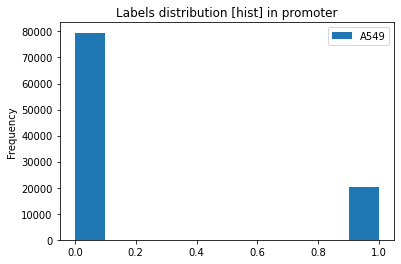

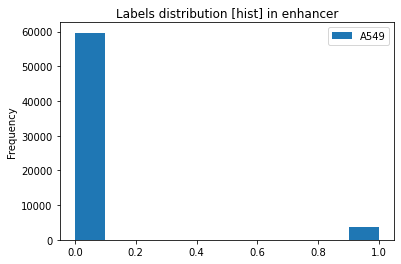

In [23]:
for (region, y) in labels.items():
  y.astype(int).plot.hist(title=f"Labels distribution [hist] in {region}")



In [24]:
for (region, y) in labels.items():
  print("active {} are {}% respect to total class".format(region, (y['A549'][y['A549']==True].count()*100) / y['A549'][y['A549']==False].count()))

active promoter are 25.63015697323405% respect to total class
active enhancer are 6.036996079219866% respect to total class


The classes, overall enhancer class, are very unbalance, but we don't will balance the classes like write in [Bayesian optimization improves tissue-specific prediction of active regulatory regions with deep neural networks](https://gvalentinib.ariel.ctu.unimi.it/v5/frm3/Download.aspx?toolName=contenuti&attachmentid=1037727) paper.

# Features Correlation & Features Selection

In [ ]:
p_value_threshold = 0.01
correlation_threshold = 0.05

In [ ]:
not_correlated_features = {'promoter':set(), 'enhancer':set()}

### Linear correlation with Pearson index


In [ ]:
from scipy.stats import pearsonr

for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|          | 0/48 [00:00<?, ?it/s]

In promoter the feature EHMT2 does not correlate in a statistically significant manner with the output. p-value:0.6607639996659921 -- correlation:-0.0013886359156064544
In promoter the feature FOSB does not correlate in a statistically significant manner with the output. p-value:0.9177470343200469 -- correlation:0.000326773556940994
In promoter the feature RNF2 does not correlate in a statistically significant manner with the output. p-value:0.9661644733045671 -- correlation:-0.00013422304928378294


Running Pearson test:   0%|          | 0/48 [00:00<?, ?it/s]

In enhancer the feature ZC3H11A does not correlate in a statistically significant manner with the output. p-value:0.039427698262771455 -- correlation:0.008187547698984091
In enhancer the feature CBX2 does not correlate in a statistically significant manner with the output. p-value:0.33286027104303706 -- correlation:-0.003849437882064245


### Linear correlation with Spearman index

In [ ]:
from scipy.stats import spearmanr

for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|          | 0/48 [00:00<?, ?it/s]

In promoter the feature ZFP36 does not correlate in a statistically significant manner with the output. p-value:0.1043890666226243 -- correlation:0.005138431133429463


Running Pearson test:   0%|          | 0/48 [00:00<?, ?it/s]

In enhancer the feature CBX2 does not correlate in a statistically significant manner with the output. p-value:0.7640592944823815 -- correlation:-0.0011931716306596745
In enhancer the feature KDM5A does not correlate in a statistically significant manner with the output. p-value:0.3410897699898755 -- correlation:-0.003784426428309876


In [ ]:
not_correlated_features

{'enhancer': {'CBX2', 'KDM5A', 'ZC3H11A'},
 'promoter': {'EHMT2', 'FOSB', 'RNF2', 'ZFP36'}}

### Not linear correlation with MIC

In [ ]:
from minepy import MINE
import os
import json

if os.path.exists('/drive/MyDrive/bioinformatics/not_linear_correlation_json.json'):
  with open('/drive/MyDrive/bioinformatics/not_linear_correlation_json.json', 'r') as fp:
      not_linear_correlation = json.load(fp)
else:
  not_linear_correlation = {'promoter':set(), 'enhancer':set()}
  for (X,y) in zip(samples.items(), labels.items()):
    for items in not_correlated_features.items():
      for feature in tqdm(items[1], desc=f"Running MINE test", dynamic_ncols=True, leave=False):
          mine = MINE()
          mine.compute_score(X[1][feature].ravel(), y[1].values.ravel())
          score = mine.mic()
          if score < correlation_threshold:
              print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output.")
              not_linear_correlation[items[0]].add(feature)
  
  for region in not_linear_correlation.items():
    not_linear_correlation[region[0]] = list(region[1])

  json_object = json.dumps(not_linear_correlation, indent = 4)
  with open('/drive/MyDrive/not_linear_correlation_json.json', 'w') as writefile:
    writefile.write(json_object)

### Drop features not correlated with output

In [ ]:
for region in samples.items():
  print(region[1].shape)

(99881, 48)
(63285, 48)


In [ ]:
for region in samples.items():
  region[1].drop(list(not_linear_correlation[region[0]]), axis=1, inplace=True)

In [ ]:
for region in samples.items():
  print(region[1].shape)

(99881, 44)
(63285, 42)


### Correlation with features

In [ ]:
from scipy.stats import spearmanr

@Cache(
    cache_path="/drive/MyDrive/bioinformatics/spearmanr/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_spearmanr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Spearman correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = spearmanr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

highly_correlated_future = {'promoter':[], 'enhancer':[]}

for X in tqdm(samples.items(), desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
  for feature_left in tqdm(X[1].columns, dynamic_ncols=True, leave=False):
      for feature_right in X[1].columns:
          if feature_left >= feature_right:
              continue
          pearson_result = compute_spearmanr(
              X[1],
              feature_left,
              feature_right,
              cell_line=cell_line,
              region="promoters"
          )
          if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.99:
              correlation = pearson_result["correlation"]
              print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
              highly_correlated_future.append(feature_left)

              

Running Spearman test:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
for region in samples.items():
  print(region[1].shape)

(99881, 44)
(63285, 42)


In [ ]:
for region in samples.items():
  region[1].drop(highly_correlated_future[region[0]], axis=1, inplace=True)

In [ ]:
for region in samples.items():
  print(region[1].shape)

(99881, 44)
(63285, 42)


### Features selection with boruta

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count

@Cache(
    cache_path=[
        "/drive/MyDrive/bioinformatics/boruta/kept_features_{_hash}.json",
        "/drive/MyDrive/bioinformatics/boruta/discarded_features_{_hash}.json"
    ],
    args_to_ignore=[
        "X_train", "y_train"
    ]
)
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    regression: bool,
    task_name: str,
    max_iter: int = 100
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # According to the requested task we build either a random forest regressor
    # or a random forest classifier.
    if regression:
        model = RandomForestRegressor(n_jobs=cpu_count(), max_depth=5)
    else:
        model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        model,
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=False,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

# Import Sequence Data

In [ ]:
from ucsc_genomes_downloader import Genome

genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [ ]:
sequence = {'promoter':pd.DataFrame(
                        np.array(BedSequence(
                            genome,
                            bed=to_bed(labels['promoter']),
                            batch_size=1
                        )).reshape(-1, 4*256),
                        index=labels['promoter'].index
                    )
            , 
            'enhancer': pd.DataFrame(
                        np.array(BedSequence(
                            genome,
                            bed=to_bed(labels['enhancer']),
                            batch_size=1
                        )).reshape(-1, 4*256),
                        index=labels['enhancer'].index
                    )
          }

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
sequence

{'enhancer':                                    0     1     2     ...  1021  1022  1023
 chrom chromStart chromEnd  strand                    ...                  
 chr10 100006381  100006637 .        1.0   0.0   0.0  ...   0.0   1.0   0.0
       100008146  100008402 .        1.0   0.0   0.0  ...   0.0   0.0   0.0
       100014418  100014674 .        0.0   0.0   0.0  ...   0.0   0.0   0.0
       100020216  100020472 .        1.0   0.0   0.0  ...   0.0   1.0   0.0
       100043528  100043784 .        0.0   0.0   0.0  ...   0.0   1.0   0.0
 ...                                 ...   ...   ...  ...   ...   ...   ...
 chrY  7520247    7520503   .        1.0   0.0   0.0  ...   1.0   0.0   0.0
       7724272    7724528   .        1.0   0.0   0.0  ...   0.0   0.0   1.0
       7770029    7770285   .        0.0   0.0   0.0  ...   0.0   0.0   1.0
       7796295    7796551   .        1.0   0.0   0.0  ...   0.0   1.0   0.0
       8007562    8007818   .        0.0   0.0   0.0  ...   0.0   0.0   0.0


# Data visualization with t-SNE or PCA 

In [ ]:
tasks = {
    "x":[
        *[
            val.values
            for val in samples.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ]
    ],
    "titles":[
        "Epigenomes promoters",
        "Epigenomes enhancers"
    ]
}

tasks


xs = tasks["x"]
ys = tasks["y"]
titles = tasks["titles"]

assert len(xs) == len(ys) == len(titles)

for x, y in zip(xs, ys):
    assert x.shape[0] == y.shape[0]

In [ ]:
tasks_seq = {
    "x":[
        *[
            val.values
            for val in sequence.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ]
    ],
    "titles":[
        "Sequence promoters",
        "Sequence enhancers"
    ]
}

tasks_seq


xss = tasks_seq["x"]
yss = tasks_seq["y"]
titless = tasks_seq["titles"]

assert len(xss) == len(yss) == len(titless)

for x, y in zip(xss, yss):
    assert x.shape[0] == y.shape[0]

### PCA decomposition

In [ ]:
from sklearn.decomposition import PCA

def pca(x:np.ndarray)->np.ndarray:
    return PCA(n_components=2, random_state=42).fit_transform(x)

Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

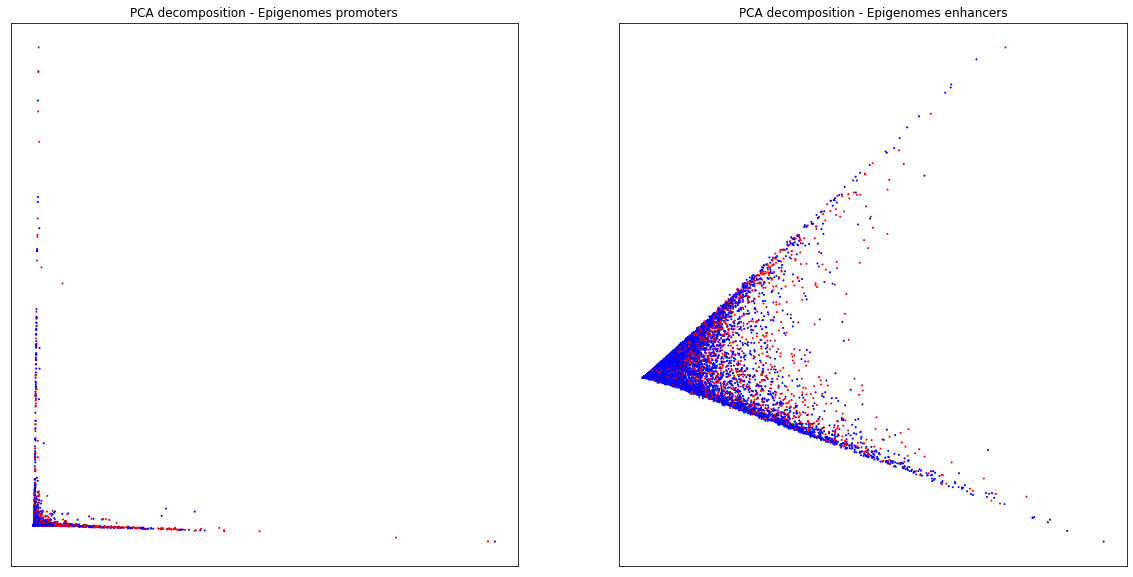

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing PCAs", total=len(xs)):
    axis.scatter(*pca(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

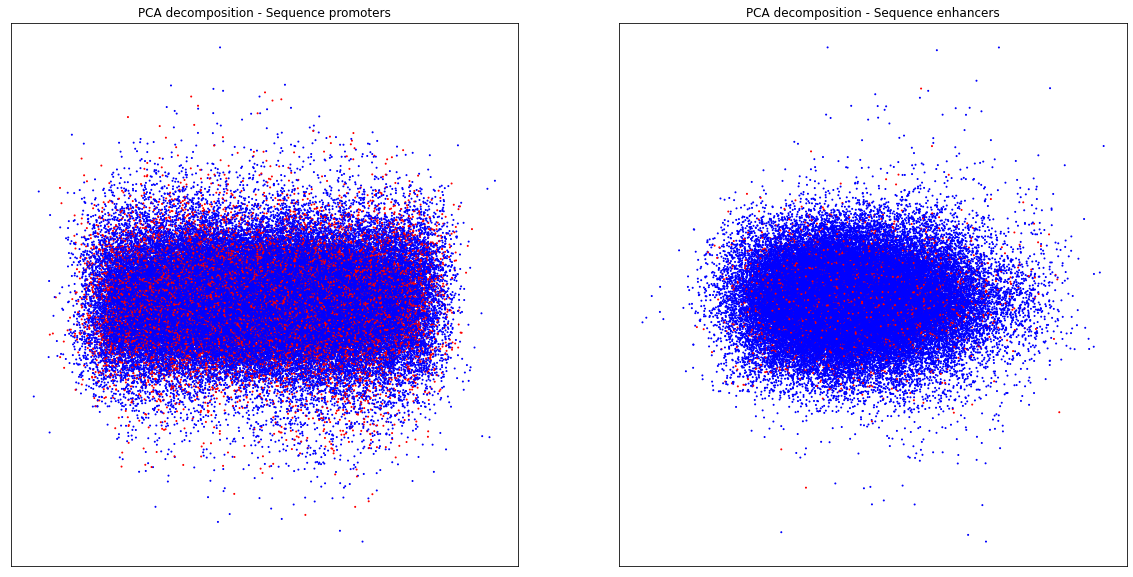

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xss, yss, titless, axes.flatten()), desc="Computing PCAs", total=len(xss)):
    axis.scatter(*pca(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

### t-SNE decomposition

In [ ]:
import gc
import tsnecuda
from tsnecuda import TSNE
import multiprocessing
from multiprocessing import Process, Queue

def tsne(X:np.ndarray)->np.ndarray:
    return TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            perplexity= 30,
            n_iter = 1000,
            verbose=True,
        ).fit_transform(X)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing t-SNE", total=len(xs)):
    axis.scatter(*tsne(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"t-SNE decomposition - {title}")
plt.show()

Computing t-SNE:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xss, yss, titless, axes.flatten()), desc="Computing t-SNE", total=len(xss)):
    axis.scatter(*tsne(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"t-SNE decomposition - {title}")
plt.show()

# Classification Model

### FFNN model

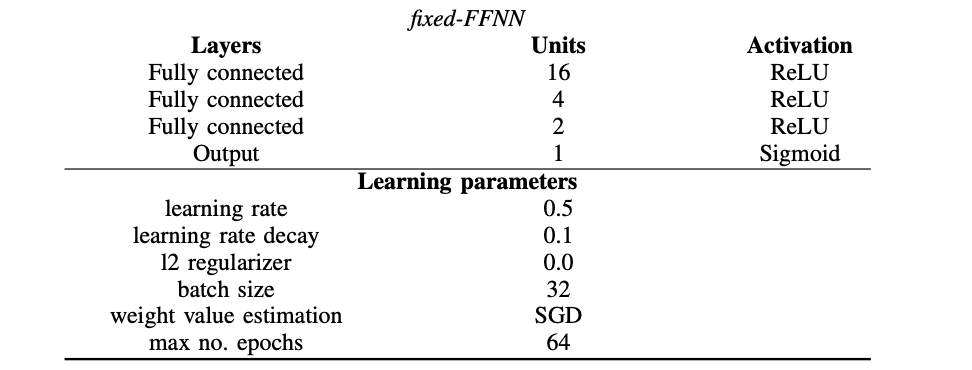

In [58]:
class MyHyperModel(kt.HyperModel):
  
  def __init__(self, input_shape):
    self.input_shape = input_shape    

  def build(self, hp):

    hp1 = hp.Choice('hp1', [8, 16, 32])
    hp2 = hp.Choice('hp2', [4, 8, 16])
    hp3 = hp.Choice('hp3', [2, 4, 8])

    input_epigenomic_data = Input(shape=(self.input_shape,), name="epigenomic_data")
    hidden = Dense(hp1, activation="relu")(input_epigenomic_data)
    #hidden = Dropout(rate=0.3)(hidden)
    hidden = Dense(hp2, activation="relu")(hidden)
    #hidden = Dropout(rate=0.3)(hidden)
    hidden = Dense(hp3, activation="relu")(hidden)
    #hidden = Dropout(rate=0.3)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryClassificationFFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return ffnn


In [59]:
def build_binary_classification_ffnn(
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    
    tuner = BayesianOptimization(
      MyHyperModel(input_shape),
      objective='val_accuracy',
      max_trials=2
    )

    tuner.search(
      train_sequence,
      validation_data=test_sequence,
      epochs=100,
      verbose=False,
      callbacks=[
          EarlyStopping(
              "loss",
              min_delta=0.001,
              patience=2,
              mode="min"
          )
      ]
    )

    return tuner.get_best_models()[0]

In [26]:
def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### CNN model

### MMNN Model

### Model training

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

'''@Cache(
    cache_path=[
        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)'''
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=100,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            #TqdmCallback(verbose=1)
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

# Here for speed sake we are only doing two holdouts
# but normally at least 10 are executed
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

regression_holdouts_generator = ShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

### Model Evaluation

### Bayesian Optimization

In [31]:
X = samples['promoter']
y = labels['promoter']

    model = keras.Sequential()

    hp1 = hp.Choice('hp1', [8, 16, 32])
    hp2 = hp.Choice('hp2', [4, 8, 16])
    hp3 = hp.Choice('hp3', [2, 4, 8])

    model.add(keras.layers.Dense(units=hp1, activation='relu'))
    model.add(keras.layers.Dense(units=hp2, activation='relu'))
    model.add(keras.layers.Dense(units=hp3, activation='relu'))

    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
      optimizer="nadam",
      loss="binary_crossentropy",
      metrics=get_complete_binary_metrics()
    )
    return model

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data

# Create a list to store all the computed performance
all_binary_classification_performance = []

training_histories = {}

# For each task
for task in tqdm(((samples['promoter'],labels['promoter'], 'Promoter'),), desc="Tasks"):

    # We get the task data with binarized labels
    X, y, task_name = task
    training_histories[task_name] = []
    # Get the number of features of this specific dataset
    number_of_features = X.shape[1]
    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc="Computing holdouts"
    ):
        # Get the training and test data
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        
        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        train_sequence = get_ffnn_sequence(train_X.values, train_y)
        test_sequence = get_ffnn_sequence(test_X.values, test_y)
        ffnn = build_binary_classification_ffnn(train_sequence, test_sequence, number_of_features)
        
        # execute_boruta_feature_selection(...)
        
        # We compute the model performance
        history, performance = train_model(
            ffnn,
            ffnn.name,
            task_name,
            cell_line,
            train_sequence,
            test_sequence,
            holdout_number
        )
        training_histories[task_name].append(history)
        all_binary_classification_performance.append(performance)
        
# We convert the computed performance list into a DataFrame
all_binary_classification_performance = pd.concat(all_binary_classification_performance)

Tasks:   0%|          | 0/1 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

WARN:tensorflow:Unresolved object in checkpoint: (root).optimizer.iter
WARN:tensorflow:Unresolved object in checkpoint: (root).optimizer.beta_1
WARN:tensorflow:Unresolved object in checkpoint: (root).optimizer.beta_2
WARN:tensorflow:Unresolved object in checkpoint: (root).optimizer.decay
WARN:tensorflow:Unresolved object in checkpoint: (root).optimizer.learning_rate
WARN:tensorflow:Unresolved object in checkpoint: (root).optimizer.momentum_cache
WARN:tensorflow:A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics for details.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1841: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1841: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1841: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1841: UserWarning: Metric MissRate implements a `reset_states()` method; rena

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


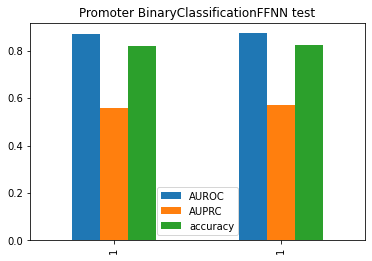

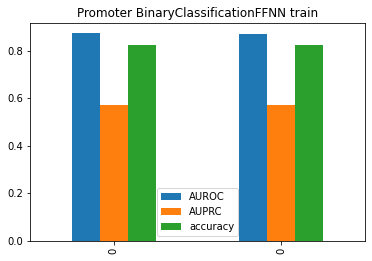

In [62]:
groups = all_binary_classification_performance[["AUROC","AUPRC","accuracy","task", "model_name", "run_type"]].groupby(["task", "model_name", "run_type"])

for title, group in groups:
  group.plot.bar(title=' '.join(title))

In [63]:
all_binary_classification_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,fall_out,mcc,true_positives_over_total,false_positives_over_total,true_negatives_over_total,false_negatives_over_total,negative_predictive_value,false_discovery_rate,false_omission_rate,prevalence_threshold,threat_score,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,model_name,task,holdout_number
0,0.338683,0.823676,0.469848,0.584389,0.872467,0.572921,0.520896,0.692104,0.914359,0.530152,0.085641,0.418115,0.095853,0.068169,0.727823,0.108155,0.870625,0.415611,0.129375,0.299197,0.352170,0.692104,0.523998,0.455014,5.486275,0.579806,2.247849,train,BinaryClassificationFFNN,Promoter,0
1,0.343705,0.820193,0.463445,0.573467,0.868410,0.560342,0.512619,0.687543,0.911641,0.536555,0.088359,0.407343,0.094559,0.070331,0.725634,0.109476,0.868908,0.426533,0.131092,0.303933,0.344645,0.687543,0.515529,0.442375,5.244999,0.588560,2.200437,test,BinaryClassificationFFNN,Promoter,0
0,0.339317,0.823776,0.456904,0.587567,0.872001,0.571096,0.514063,0.687354,0.917803,0.543096,0.082197,0.413306,0.093212,0.065429,0.730564,0.110795,0.868314,0.412433,0.131686,0.297825,0.345952,0.687354,0.518133,0.455881,5.558619,0.591734,2.198501,train,BinaryClassificationFFNN,Promoter,1
1,0.339105,0.825900,0.454858,0.596141,0.872990,0.572503,0.516003,0.687935,0.921011,0.545142,0.078989,0.417798,0.092807,0.062872,0.733093,0.111228,0.868263,0.403859,0.131737,0.294144,0.347712,0.687935,0.520730,0.464405,5.758506,0.591895,2.204455,test,BinaryClassificationFFNN,Promoter,1
